# 人脸红眼去除算法

In [1]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

In [2]:
src = cv2.cvtColor(cv2.imread('../datas/redeye.jpg'),cv2.COLOR_BGR2RGB)

In [3]:
def redeye_remove(src):
    rows,cols = src.shape[0],src.shape[1]
    rgb = np.float64(src)
    dst = rgb.copy()
    
    for i in range(rows):
        for j in range(cols):
            r = rgb[i,j,0]
            g = rgb[i,j,1]
            b = rgb[i,j,2]
            
            if r > (g + b):
                rc = (g + b )/ 2
                gc = (g + rc) / 2
                bc = (b + rc) / 2
                dst[i,j,0] = rc
                dst[i,j,1] = gc
                dst[i,j,2] = bc
                
    return cv2.convertScaleAbs(dst)

In [34]:
def fillHoles(mask):
    '''
        This hole filling algorithm is decribed in this post
        https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/
    '''
    maskFloodfill = mask.copy()
    h, w = maskFloodfill.shape[:2]
    maskTemp = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(maskFloodfill, maskTemp, (0, 0), 255)
    mask2 = cv2.bitwise_not(maskFloodfill)
    return mask2 | mask

In [35]:
def redeye_remove2(src):
    r = src[:,:,0]
    g = src[:,:,1]
    b = src[:,:,2]
    
    bg = cv2.add(b,g)
    mask = (r > 150) & (r > (bg * 2.6))
    mask = mask.astype(np.uint8) * 255
    mask = fillHoles(mask)
    mask = cv2.dilate(mask,None,anchor=(-1,-1),iterations=3,borderType=1,borderValue=1)
    
    mean = bg // 2
    mask = mask.astype(np.bool)[:,:,np.newaxis]
    mean = mean[:,:,np.newaxis]
    
    eyeOut = src.copy()
#     eyeOut = np.where(mask,mean,eyeOut)
    np.copyto(eyeOut,mean,where=mask)
    return eyeOut.astype(np.uint8)

In [53]:
def redeye_remoe3(src,p):
    rgb = src.astype(np.float32)
    r = rgb[:,:,0]
    g = rgb[:,:,1]
    b = rgb[:,:,2]

    nr =  r * (1.0 - p) + p * (r + g) / 2
    dst = src.copy()
    dst[:,:,0] = nr.astype(np.uint8)
    return dst

In [82]:
def redeye_fixing(img):
    faceCascade = cv2.CascadeClassifier("../datas/haarcascade_frontalface_default.xml")
    eyesCascade = cv2.CascadeClassifier("../datas/haarcascade_eye.xml")
    
    # 定位脸部
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.3, 5)
    dst = src.copy()##
    # 定位眼睛
    eye_imgs = []
    for (x,y,w,h) in faces:
        roiGray = gray[y:y+h, x:x+w]
        roiColor = img[y:y+h, x:x+w]
        eyes = eyesCascade.detectMultiScale(roiGray)
        for (ex, ey, ew, eh) in eyes:
            eye = img[(y + ey):(y + ey+eh), (x + ex) :(x + ex+ew) ]
            eyeOut = redeye_remove2(eye.copy())
            dst[(y + ey):(y + ey+eh), (x + ex) :(x + ex+ew) ] = eyeOut
#             eye_imgs.append((ex+x, ey+y, ew+x+ex, eh+ey+y))
    if len(eye_imgs) == 0:
        eyes = eyesCascade.detectMultiScale(gray)
        for  (ex, ey, ew, eh) in eyes:
            print(ex, ey, ew, eh)
            eye = dst[ey:ey + eh, ex :ex + ew ]
            eyeOut = redeye_remoe3(eye.copy(),0.8)
            dst[ey:(ey+eh), ex :(ex+ew) ] = eyeOut
    return dst,eyes

In [83]:
dst,eyes = redeye_fixing(src)

108 169 99 99
519 324 20 20
294 195 103 103


In [84]:
print(eyes)

[[108 169  99  99]
 [519 324  20  20]
 [294 195 103 103]]


Text(0.5,1,'Redeye Remove')

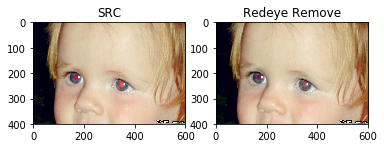

In [85]:
plt.subplot(121)
plt.imshow(src)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('Redeye Remove')

参考：

[1]. https://blog.csdn.net/trent1985/article/details/45095905